# Predicting Air Delays
Notebook III: Machine Learning model and predictions
----

Thank you for your review of my code notebook.
This notebook's goal is to analyze and prepare the dataset for exposure on a Machine Learning algorithm.

---
#### Problem Statement: 
Both travelers and airlines find delays frustrating and costly. This project attempts to be able to predict the probability of a commercial flight delay for any flight in the United States.

---

#### MVP:
My product will be a small lightweight application run on `streamlit` platform for proof-of-concept where a user can find the probability of their desired flight having a delay, how long the delay may be, and how much will the delay cost the user in _lost time_ at the destination.

Since we have labels on all our data, the model the app will be based on is a supervised multi-class classification machine learning model.

---
# Modeling 

The primary challenge in this notebook is running models on a volume of data in the millions of instances. 

The notebook is structured as follows.<br> 
**Notebook III: Modeling **
>1. Setup/Imports
>2. Load data
>3. Class Balances and Training Set + Validation Set.
>4. Modeling and Model Selection
>5. Save the final model and discuss next steps. 

The processed model will be saved on a new file by the end of this notebook and called into the subsequent that builds an application.

The notebooks in this project are: <br>
I. Intake and cleaning<br>
II. EDA and preprocessing<br>
**III. Modeling and predictions**<br>
IV. App<br>

---

## 1. Setup and Imports
----

In [57]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


#utilities
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, KFold, cross_validate, RepeatedStratifiedKFold
from sklearn.metrics import mean_squared_error, roc_auc_score, f1_score, mean_absolute_error, precision_score, recall_score, plot_roc_curve, confusion_matrix, plot_confusion_matrix, RocCurveDisplay




#models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier, plot_importance
from lightgbm import LGBMClassifier


I am utilizing Light GBM as my primary model of choice due to the tabular and labeled nature of our problem. 
The shape of our dataset would effectively require as fast of processing time as possible. 

In [ ]:
!pip install lightgbm

In [ ]:
!pip install imbalanced-learn

In [2]:
os.chdir('/Volumes/lacie/data_ingestion/capstone_hopper')

In [4]:
#pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)

## 2. Loading Data
---



In [3]:
flights = pd.read_csv('flights_processed_ex_dummies.csv')

In [4]:
flights.shape

(2735655, 28)

In [5]:
#check for null corruption
flights.isnull().sum().sum()

0

Pandas infers datatypes. So,  we have to cast certain categorical variables that are represented with numbers as _strings_ so we can then encode them using Pandas. 

In [6]:
#use a mask to find categorical columns
flights.dtypes

year                     int64
month                   object
day_of_month             int64
day_of_week             object
fl_date                 object
airline                 object
tail_num                object
op_carrier_fl_num        int64
origin                  object
origin_city_name        object
dest                    object
dest_city_name          object
crs_dep_time             int64
dep_time               float64
dep_delay              float64
crs_arr_time             int64
arr_time               float64
arr_delay              float64
cancelled              float64
cancellation_code       object
distance               float64
carrier_delay          float64
weather_delay          float64
nas_delay              float64
security_delay         float64
late_aircraft_delay    float64
delay_class             object
markets                 object
dtype: object

In [7]:
#numerical represented categories converted to string
categorical = {'year' : str,
               'day_of_month': str,  
              'op_carrier_fl_num': str, 
               'crs_dep_time': str, 
               'dep_time' : str,
               'dep_delay': str,
               'crs_dep_time' : str,
               'crs_arr_time': str, 
               'arr_time' : str,
              'arr_delay':str,
              }

In [8]:
flights = flights.astype(categorical)

In [9]:
#dropping categorical data that will not be used. 
flights = flights.drop(columns = ['fl_date', 'origin_city_name', 'dest_city_name'])

In [10]:
flights.dtypes

year                    object
month                   object
day_of_month            object
day_of_week             object
airline                 object
tail_num                object
op_carrier_fl_num       object
origin                  object
dest                    object
crs_dep_time            object
dep_time                object
dep_delay               object
crs_arr_time            object
arr_time                object
arr_delay               object
cancelled              float64
cancellation_code       object
distance               float64
carrier_delay          float64
weather_delay          float64
nas_delay              float64
security_delay         float64
late_aircraft_delay    float64
delay_class             object
markets                 object
dtype: object

## Establishing classes for the algorithm
---
We know that our problem can be either a binary classification task or a multiclass classification task. 
In the initial outset I will run a binary model to see how accurate we can get a `will be delayed` or `won't be delayed` prediction.
I will just briefly reconfigure the data and then we will take a fractional sample of the data. 

In [11]:
#create new class for binary problem
flights['delayed'] = flights['delay_class'].apply(lambda x: 1 if x != 'no delay' else 0)

In [12]:
#Target class balance
flights['delayed'].value_counts( normalize =True)

1    0.50805
0    0.49195
Name: delayed, dtype: float64

In [13]:
#dropping all other delay related categories
flights = flights.drop(columns =['carrier_delay', 'weather_delay', 'nas_delay', 'security_delay','late_aircraft_delay', 'delay_class'])

### SubSample for the Training and testing setup. 
----
Next we are going to take a sample and then measure what we need to do with our categorical columns

In [14]:
ontime = flights[flights['delayed']==0]
delayed = flights[flights['delayed']==1]

In [15]:
sample_0 = ontime.sample(n = 100_000, random_state =42, ignore_index = True)
sample_1 = delayed.sample(n = 100_000, random_state =42, ignore_index = True)

In [16]:
sample = sample_0.append(sample_1, ignore_index = True)

In [17]:
sample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 20 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   year               200000 non-null  object 
 1   month              200000 non-null  object 
 2   day_of_month       200000 non-null  object 
 3   day_of_week        200000 non-null  object 
 4   airline            200000 non-null  object 
 5   tail_num           200000 non-null  object 
 6   op_carrier_fl_num  200000 non-null  object 
 7   origin             200000 non-null  object 
 8   dest               200000 non-null  object 
 9   crs_dep_time       200000 non-null  object 
 10  dep_time           200000 non-null  object 
 11  dep_delay          200000 non-null  object 
 12  crs_arr_time       200000 non-null  object 
 13  arr_time           200000 non-null  object 
 14  arr_delay          200000 non-null  object 
 15  cancelled          200000 non-null  float64
 16  ca

In [18]:
sample

,year,month,day_of_month,day_of_week,airline,tail_num,op_carrier_fl_num,origin,dest,crs_dep_time,dep_time,dep_delay,crs_arr_time,arr_time,arr_delay,cancelled,cancellation_code,distance,markets,delayed
0,2019,May,20,Mon,Southwest Airlines,N486WN,1793,MAF,DAL,525,521.0,0.0,635,632.0,0.0,0.0,completed_flight,319.0,MAF_DAL,0
1,2019,Oct,18,Fri,American Airlines,N667AW,1794,CLT,RDU,1620,1617.0,0.0,1720,1718.0,0.0,0.0,completed_flight,130.0,CLT_RDU,0
2,2019,Aug,1,Thu,Envoy Air,N668HH,3530,CLE,MIA,557,552.0,0.0,858,837.0,0.0,0.0,completed_flight,1080.0,CLE_MIA,0
3,2017,Mar,10,Fri,Alaska Airlines,N527AS,342,SEA,OAK,610,558.0,0.0,811,808.0,0.0,0.0,completed_flight,672.0,SEA_OAK,0
4,2021,Jan,30,Sat,Southwest Airlines,N8551Q,1711,BNA,HOU,1520,1513.0,0.0,1735,1712.0,0.0,0.0,completed_flight,670.0,BNA_HOU,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,2018,Mar,22,Thu,Southwest Airlines,N431WN,2014,SLC,PHX,2125,2155.0,30.0,2200,2235.0,35.0,0.0,completed_flight,507.0,SLC_PHX,1
199996,2016,Jun,6,Mon,Delta Airlines,N934AT,2444,LAX,OAK,2220,2247.0,27.0,2345,6.0,21.0,0.0,completed_flight,337.0,LAX_OAK,1
199997,2018,Dec,26,Wed,American Airlines,N840AW,1784,IAH,LAX,1357,1354.0,0.0,1543,1605.0,22.0,0.0,completed_flight,1379.0,IAH_LAX,1
199998,2019,Aug,18,Sun,Envoy Air,N676AE,3721,GNV,MIA,1527,1634.0,67.0,1643,1742.0,59.0,0.0,completed_flight,294.0,GNV_MIA,1


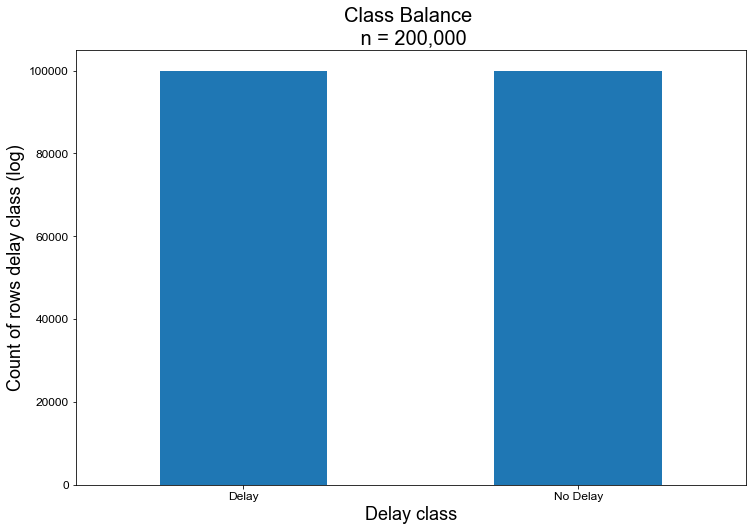

In [19]:
fig, ax = plt.subplots();
sample['delayed'].value_counts().plot(kind ='bar', figsize = (12,8));
ticks = ax.get_xticks()
sns.set_style('darkgrid')
plt.title(f'Class Balance \n n = {sample.shape[0] :,}', size = 20);
plt.xticks(ticks = ticks, labels =['Delay','No Delay'], rotation = 0, fontsize = 12)
plt.xlabel('Delay class', size = 18 )
plt.ylabel('Count of rows delay class (log)', size = 18 )
plt.yticks(fontsize = 12);
plt.savefig("../Assets/class_imbal.pdf", bbox_inches="tight")

## Categorical Column encoding
----
We will encode our categorical columns in this section and then join them to the numeric columns to establish our X values.

In [20]:
sample.columns

Index(['year', 'month', 'day_of_month', 'day_of_week', 'airline', 'tail_num',
       'op_carrier_fl_num', 'origin', 'dest', 'crs_dep_time', 'dep_time',
       'dep_delay', 'crs_arr_time', 'arr_time', 'arr_delay', 'cancelled',
       'cancellation_code', 'distance', 'markets', 'delayed'],
      dtype='object')

In [21]:
y = sample['delayed']
sample = sample.drop(columns = ['delayed'])

In [22]:
#need to remove related delay columns to prevent data leakage.
drop = [col for col in sample.columns if 'delay' in col]
drop_c = [col for col in sample.columns if 'cancel' in col]
drop, drop_c

(['dep_delay', 'arr_delay'], ['cancelled', 'cancellation_code'])

In [23]:
sample = sample.drop(columns = drop)
sample = sample.drop(columns = drop_c)

In [24]:
cat_cols = sample.select_dtypes(include=['object'])

In [25]:
cat_cols.shape

(200000, 14)

In [26]:
#need write a function that finds how many unique instances there are and print it out for each object column
# this will inform the complexity of OHE process.
def uniqueness(df, threshold=10):
    '''
    Measure the n_unique values for each categorical column. This will help us decide which columns to OHE. 
    Takes a dataframe as an arguement, and an integer to delinate the keep/drop decision. That is, if n_unique is too complex (above threshold), then consider dropping. 
    The function prints results and returns a keep and drop list of columns. 
    '''
    col_keep = []
    col_keep_count = []
    col_drop = []
    col_drop_count = []
    for col in df.columns:
        ux = df[f'{col}'].nunique()
        print(f"Column-- \'{col}\' -- contains {ux} unique labels")
        if ux > threshold:
            col_drop.append(f'{col}')
            col_drop_count.append(ux)
        else:
            col_keep.append(f'{col}')
            col_keep_count.append(ux)
    print('*'*30)
    print(f"the total number of new OHE columns is {sum(col_keep_count)}")
    print('*'*30)
    return col_keep, col_drop

In [27]:
keepers, drop = uniqueness(cat_cols, 1000)
print('keep: ', keepers)
print('drop: ',drop)

Column-- 'year' -- contains 6 unique labels
Column-- 'month' -- contains 12 unique labels
Column-- 'day_of_month' -- contains 31 unique labels
Column-- 'day_of_week' -- contains 7 unique labels
Column-- 'airline' -- contains 17 unique labels
Column-- 'tail_num' -- contains 7438 unique labels
Column-- 'op_carrier_fl_num' -- contains 6866 unique labels
Column-- 'origin' -- contains 379 unique labels
Column-- 'dest' -- contains 374 unique labels
Column-- 'crs_dep_time' -- contains 1301 unique labels
Column-- 'dep_time' -- contains 1400 unique labels
Column-- 'crs_arr_time' -- contains 1398 unique labels
Column-- 'arr_time' -- contains 1440 unique labels
Column-- 'markets' -- contains 6505 unique labels
******************************
the total number of new OHE columns is 826
******************************
keep:  ['year', 'month', 'day_of_month', 'day_of_week', 'airline', 'origin', 'dest']
drop:  ['tail_num', 'op_carrier_fl_num', 'crs_dep_time', 'dep_time', 'crs_arr_time', 'arr_time', 'mar

In [28]:
#I actually want to keep markets intact
#drop = drop[:-1]

In [29]:
#apply the drop values to X drop
sample = sample.drop(columns = drop)


In [30]:
sample.dtypes

year             object
month            object
day_of_month     object
day_of_week      object
airline          object
origin           object
dest             object
distance        float64
dtype: object

In [31]:
X = pd.get_dummies(sample, columns = keepers)

In [32]:
X.columns

Index(['distance', 'year_2016', 'year_2017', 'year_2018', 'year_2019',
       'year_2020', 'year_2021', 'month_Apr', 'month_Aug', 'month_Dec',
       ...
       'dest_VEL', 'dest_VLD', 'dest_VPS', 'dest_WRG', 'dest_WYS', 'dest_XNA',
       'dest_XWA', 'dest_YAK', 'dest_YKM', 'dest_YUM'],
      dtype='object', length=827)

In [33]:
X.shape

(200000, 827)

In [34]:
[col for col in X.columns if "delay" in col]

[]

Our task is to utilize a supervised learning model to make predictions. We want to limit the imbalance on the classes we are attempting to predict so, we are left with some decisions to make on our dataset. 

### Training and Target variables set up.
----
Our features and target variables were encoded in the previous section. 

In [35]:
X.shape, y.shape

((200000, 827), (200000,))

In [37]:
y

0         0
1         0
2         0
3         0
4         0
         ..
199995    1
199996    1
199997    1
199998    1
199999    1
Name: delayed, Length: 200000, dtype: int64

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

## 4. Modeling and Performance
----


In [39]:
cv_test = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)

In [40]:
metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']

### 4.1 ADABoost
----
The first model built will be one of our boosted classifiers. ADABoost



In [148]:
ada = AdaBoostClassifier(random_state = 42)

In [ ]:
ada_scores = cross_validate(ada, X_train, y_train, scoring = metrics, cv = cv_test, n_jobs = -1, verbose = 3)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  15 | elapsed:  2.9min remaining:  4.4min
[Parallel(n_jobs=-1)]: Done  12 out of  15 | elapsed:  5.4min remaining:  1.4min
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  5.4min finished


In [193]:
ada_scored = pd.DataFrame(ada_scores)#.add_prefix('AdaBoost_')
print(ada_scored.mean())
ada_mean = pd.Series(ada_scored.mean(), name='AdaBoost')
ada_scored

fit_time          145.919277
score_time         17.044638
test_accuracy       0.588424
test_precision      0.582812
test_recall         0.622396
test_f1             0.601938
test_roc_auc        0.620735
dtype: float64


,fit_time,score_time,test_accuracy,test_precision,test_recall,test_f1,test_roc_auc
0,156.293644,18.155819,0.591367,0.585172,0.627733,0.605706,0.624039
1,156.632660,18.267860,0.588500,0.584046,0.615000,0.599123,0.619593
2,157.950269,18.105565,0.586900,0.579477,0.633600,0.605331,0.617959
3,155.870026,18.029161,0.590100,0.585815,0.615067,0.600085,0.622627
4,158.311084,17.991922,0.588333,0.582647,0.622733,0.602024,0.620044
5,158.296528,18.009436,0.585633,0.579867,0.621733,0.600071,0.619145
6,158.740916,17.866016,0.589133,0.583209,0.624733,0.603257,0.621998
7,156.527121,17.483232,0.591633,0.585837,0.625400,0.604972,0.624303
8,132.847756,16.287848,0.587500,0.580675,0.629800,0.604241,0.618542
9,132.808335,16.383870,0.585167,0.579949,0.617800,0.598276,0.619181


### 4.2 Light GBM
----


In [39]:
light = LGBMClassifier(random_state = 42)

In [40]:
light_scores = cross_validate(light, X_train, y_train, scoring = metrics, cv = cv_test, n_jobs = -1, verbose = 3)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  15 | elapsed:   22.9s remaining:   34.4s
[Parallel(n_jobs=-1)]: Done  12 out of  15 | elapsed:   34.9s remaining:    8.7s
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:   35.1s finished


In [41]:
light_scored = pd.DataFrame(light_scores)#.add_prefix('LGBMC_')
print(light_scored.mean())
light_mean = pd.Series(light_scored.mean(), name = 'LGBM')
light_scored

fit_time          13.673858
score_time         1.916300
test_accuracy      0.610693
test_precision     0.606094
test_recall        0.632378
test_f1            0.618950
test_roc_auc       0.654099
dtype: float64


,fit_time,score_time,test_accuracy,test_precision,test_recall,test_f1,test_roc_auc
0,17.117618,2.092196,0.613800,0.608906,0.636267,0.622286,0.656355
1,17.126642,2.088092,0.610733,0.607300,0.626733,0.616864,0.652347
2,17.449263,2.076916,0.610867,0.604355,0.642067,0.622640,0.652855
3,17.387970,2.077986,0.613033,0.608526,0.633800,0.620906,0.656523
4,17.336949,2.065361,0.607733,0.603630,0.627533,0.615349,0.651999
5,16.752753,2.126565,0.612133,0.606997,0.636133,0.621224,0.654350
6,16.558961,2.148808,0.611533,0.606969,0.632867,0.619648,0.655716
7,15.872479,2.327413,0.611133,0.606287,0.633933,0.619802,0.655264
8,8.771471,1.948018,0.612367,0.607775,0.633667,0.620451,0.654223
9,9.493955,1.901800,0.609100,0.605397,0.626667,0.615848,0.653378


### 4.3 XGBoost.
----


In [41]:
xg = XGBClassifier(tree_method = 'hist', random_state = 42)

In [42]:
xg_scores = cross_validate(xg, X_train, y_train, scoring = metrics, cv = cv_test, n_jobs = -1, verbose = 3)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  15 | elapsed:   47.8s remaining:  1.2min
[Parallel(n_jobs=-1)]: Done  12 out of  15 | elapsed:  1.4min remaining:   21.4s
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  1.4min finished


In [43]:
xg_scored = pd.DataFrame(xg_scores)#.add_prefix('XGBoost_')
print(xg_scored.mean())
xg_mean= pd.Series(xg_scored.mean(), name = 'XGBoost')
xg_scored

fit_time          38.688621
score_time         2.537228
test_accuracy      0.611027
test_precision     0.605752
test_recall        0.635956
test_f1            0.620478
test_roc_auc       0.653135
dtype: float64


,fit_time,score_time,test_accuracy,test_precision,test_recall,test_f1,test_roc_auc
0,41.784700,3.001996,0.613067,0.607943,0.636800,0.622037,0.656203
1,41.669928,2.855586,0.608933,0.604476,0.630267,0.617102,0.651515
2,41.767219,3.012381,0.611900,0.604625,0.646667,0.624940,0.653077
3,41.840576,2.945562,0.614767,0.609545,0.638600,0.623734,0.655050
4,41.549704,2.882432,0.606600,0.602461,0.626800,0.614389,0.651045
5,41.249822,2.697001,0.610367,0.605144,0.635200,0.619808,0.650895
6,41.534783,2.906017,0.614600,0.608797,0.641267,0.624610,0.656349
7,41.868806,2.888658,0.610233,0.605352,0.633400,0.619058,0.654632
8,34.261810,2.247735,0.610500,0.604779,0.637800,0.620851,0.651540
9,35.401185,2.006273,0.610833,0.606605,0.630667,0.618402,0.652804


### 4.4 Logistic Regression
----


In [155]:
lr = LogisticRegression()

In [156]:
lr_scores = cross_validate(lr, X_train, y_train, scoring = metrics, cv = cv_test, n_jobs = -1, verbose = 3)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  15 | elapsed:  1.3min remaining:  2.0min
[Parallel(n_jobs=-1)]: Done  12 out of  15 | elapsed:  2.1min remaining:   31.5s
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  2.2min finished


In [190]:
lr_scored = pd.DataFrame(lr_scores)#.add_prefix('LogReg_')
print(lr_scored.mean())
lr_mean = pd.Series(lr_scored.mean(), name = 'LogReg') 
lr_scored

fit_time          59.240998
score_time         1.039002
test_accuracy      0.590091
test_precision     0.585364
test_recall        0.618907
test_f1            0.601447
test_roc_auc       0.621824
dtype: float64


,fit_time,score_time,test_accuracy,test_precision,test_recall,test_f1,test_roc_auc
0,77.438148,1.175949,0.595300,0.592101,0.612667,0.602208,0.626389
1,29.429541,0.941158,0.582600,0.568795,0.682933,0.620660,0.610589
2,59.870656,1.110103,0.585800,0.580923,0.615933,0.597916,0.619068
3,56.071524,1.449291,0.591767,0.588732,0.608867,0.598630,0.622023
4,79.649925,0.870214,0.589067,0.585883,0.607600,0.596544,0.622909
5,77.313959,1.174114,0.589533,0.585738,0.611667,0.598422,0.622564
6,54.707723,1.594597,0.588233,0.583792,0.614733,0.598863,0.622944
7,72.353536,1.495722,0.594700,0.585691,0.647267,0.614941,0.626836
8,52.630185,1.575723,0.588800,0.584647,0.613333,0.598647,0.619279
9,67.351359,0.737433,0.591200,0.586968,0.615533,0.600911,0.623232


## 5. Model evaluation / selection

In [195]:
cohort = pd.concat([lr_mean, ada_mean, xg_mean, light_mean], axis=1)
cohort.T

,fit_time,score_time,test_accuracy,test_precision,test_recall,test_f1,test_roc_auc
LogReg,59.240998,1.039002,0.590091,0.585364,0.618907,0.601447,0.621824
AdaBoost,145.919277,17.044638,0.588424,0.582812,0.622396,0.601938,0.620735
XGBoost,38.502168,2.791028,0.611027,0.605752,0.635956,0.620478,0.653135
LGBM,11.917129,1.974480,0.610693,0.606094,0.632378,0.618950,0.654099


The model selected for this task is the LGBM model for its speed. In the next section we will run a grid search to find the best parameters so we may improve performance on our test set. 
Lets first see where we stand in so far as bias vs. variance is concerned. 

### 5.1 LGBM test fit and analysis. 


In [44]:
xg.fit(X_test, y_test)

/Users/nickvanbergen/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:07:17] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='hist', validate_parameters=1, verbosity=None)

/Users/nickvanbergen/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


<Figure size 864x864 with 0 Axes>

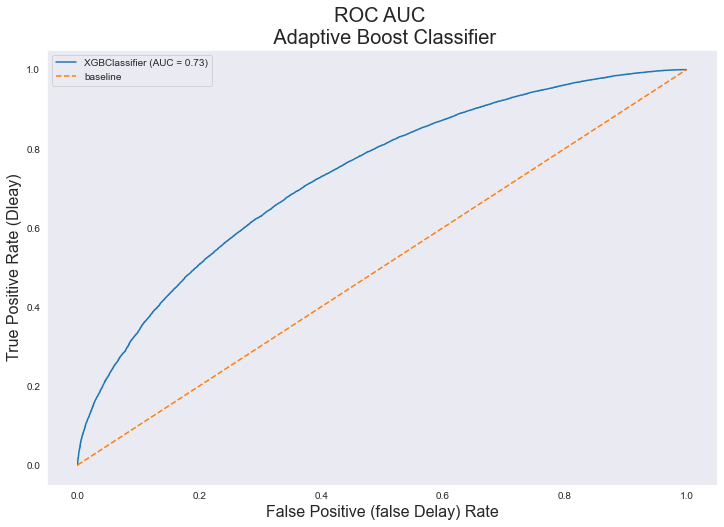

In [86]:
plt.figure(figsize = (12,12))
plot_roc_curve(xg, X_test, y_test)
plt.title('ROC AUC \n Adaptive Boost Classifier',size =20)
plt.plot([0, 1], [0, 1],
         label='baseline', linestyle='--')
plt.xlabel('False Positive (false Delay) Rate', size = 16)
plt.ylabel('True Positive Rate (Dleay)', size = 16)
plt.legend();


/Users/nickvanbergen/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


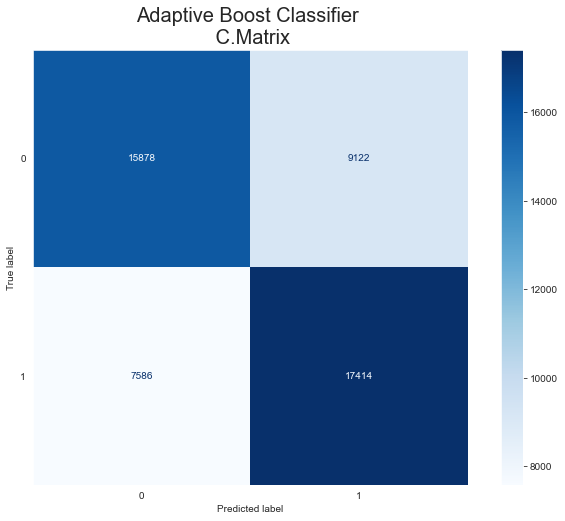

In [82]:
sns.set_style('dark')
plot_confusion_matrix(xg, X_test, y_test, cmap='Blues');
plt.title('Adaptive Boost Classifier \n C.Matrix', size= 20);

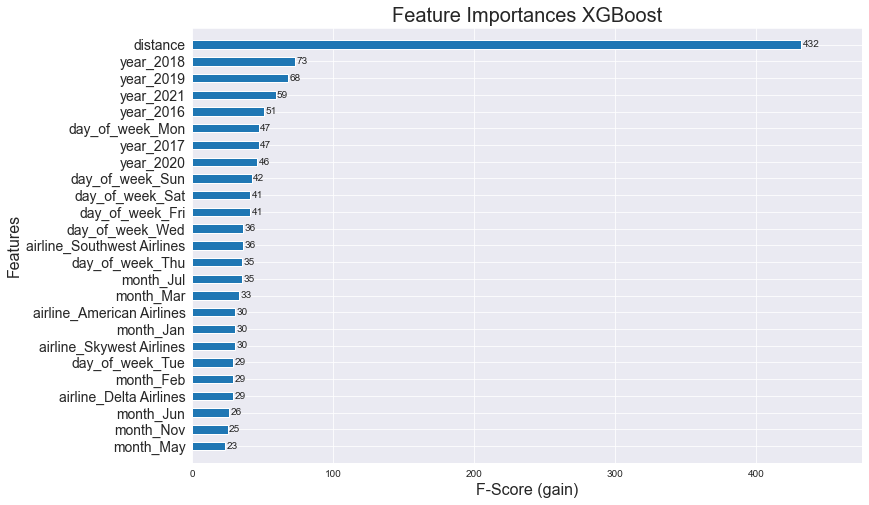

In [81]:
plt.rcParams["figure.figsize"] = (12,8);
plot_importance(xg, max_num_features=25, height = .5);
plt.title('Feature Importances XGBoost', size=20);
plt.xlabel('F-Score (gain)', size = 16);
plt.ylabel('Features', size = 16);
plt.yticks(fontsize =14);

## 5. Final Model save to disk
---
